# Mar 2, 2025: 

In [1]:
import numpy as np
import graph_tool.all as gt

adj_matrix = np.array([
    [0, 0, 0, 0, 1, 0], #1 
    [0, 0, 1, 0, 0, 1], #2
    [0, 1, 0, 0, 1, 1], #3
    [0, 0, 0, 0, 1, 1], #4
    [1, 0, 1, 1, 0, 1], #5
    [0, 1, 1, 1, 1, 0], #6
])

adj_matrix = np.triu(adj_matrix, 1) #+ np.triu(adj_matrix, 1).T
adj_matrix

edges = np.transpose(np.nonzero(adj_matrix))
edges

array([[0, 4],
       [1, 2],
       [1, 5],
       [2, 4],
       [2, 5],
       [3, 4],
       [3, 5],
       [4, 5]])

In [2]:
g = gt.Graph(directed=False)
num_nodes = adj_matrix.shape[0]
# g.add_vertex(num_nodes)
g.add_edge_list(edges, eprops=[g.new_edge_property('double')])
g

<Graph object, undirected, with 6 vertices and 8 edges, at 0x7f61805bddc0>

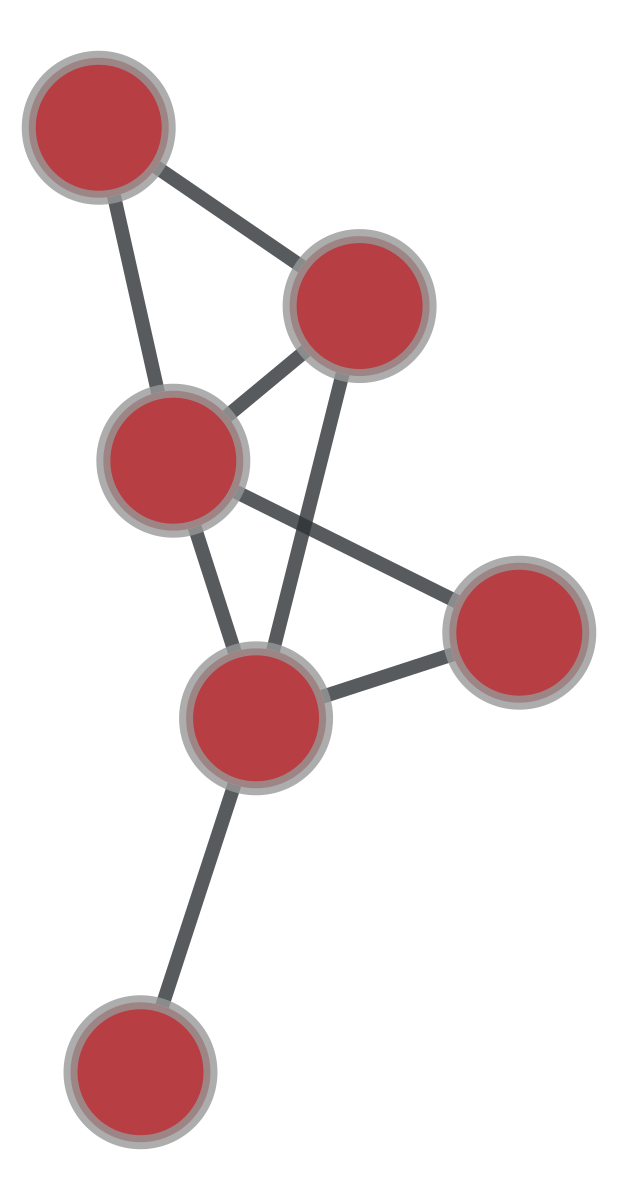

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f61805bddc0, at 0x7f61805bd1f0>

In [3]:
gt.graph_draw(g)

In [4]:
b = np.array([0, 0, 0, 0, 1, 1])
b

array([0, 0, 0, 0, 1, 1])

In [5]:
state = gt.BlockState(g, b=g.new_vp("int", vals=b))
state

<BlockState object with 2 blocks (2 nonempty), degree-corrected, for graph <Graph object, undirected, with 6 vertices and 8 edges, at 0x7f61805bddc0>, at 0x7f60e20eeeb0>

In [6]:
block_mat = state.get_matrix().todense()
# block_mat -= np.diag(np.diag(block_mat) / 2)
block_mat

matrix([[2., 6.],
        [6., 2.]])

In [7]:
block_sizes = np.array(list(state.get_nr()))
block_sizes

array([4, 2])

In [8]:
sizes_i = block_sizes[:, None]
sizes_j = block_sizes[None, :]
possible_edges = sizes_i @ sizes_j
possible_edges -= np.diag(block_sizes)
possible_edges

array([[12,  8],
       [ 8,  2]])

In [9]:
density_mat = np.divide(
    block_mat,
    possible_edges, 
    out=np.zeros_like(block_mat),
    where=possible_edges!=0,
)
density_mat

matrix([[0.16666667, 0.75      ],
        [0.75      , 1.        ]])

In [10]:
n = density_mat.shape[0]
internal_j = np.tile(np.diag(density_mat), (n, 1))
internal_i = internal_j.T
internal_i, internal_j

(array([[0.16666667, 0.16666667],
        [1.        , 1.        ]]),
 array([[0.16666667, 1.        ],
        [0.16666667, 1.        ]]))

In [11]:
rel_matrix = np.zeros((n, n), dtype=int)
rel_matrix

array([[0, 0],
       [0, 0]])

In [12]:
mask_core_i = (internal_i > density_mat) & (density_mat > internal_j)
mask_core_j = (internal_j > density_mat) & (density_mat > internal_i)
mask_assort = np.minimum(internal_i, internal_j) > density_mat
mask_disass = density_mat > np.maximum(internal_i, internal_j)

rel_matrix[mask_core_i] = 2
rel_matrix[mask_core_j] = 3
rel_matrix[mask_assort] = 1
rel_matrix[mask_disass] = 4

# np.fill_diagonal(rel_matrix, 0)
rel_matrix

array([[0, 3],
       [2, 0]])